### Import libraries

In [1]:
import numpy as np
import os
import shutil

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                  untar=True, cache_dir='.',
                  cache_subdir=''
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    label_mode='categorical',
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
class_total = len(class_names)

train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    label_mode='categorical',
    subset='validation',
    seed=seed
)

val_dataset = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    label_mode='categorical',
    batch_size=batch_size
)

test_dataset = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

84140032/84125825 [==============================] - 10s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [3]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int"
)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [4]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(class_total, activation='softmax')
])

In [5]:
epochs_round = 3
base_learning_rate = 0.0001

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
          optimizer=tf.keras.optimizers.Adam(base_learning_rate),
          metrics=['accuracy'],       
)

history = model.fit(train_dataset, epochs=epochs_round,
            validation_data=val_dataset, callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)

model.save("/content/models",save_format='tf')

Epoch 1/3
625/625 [==============================] - 60s 74ms/step - loss: 0.5923 - accuracy: 0.6601 - val_loss: 0.3949 - val_accuracy: 0.8296
Epoch 2/3
625/625 [==============================] - 43s 68ms/step - loss: 0.3597 - accuracy: 0.8469 - val_loss: 0.3500 - val_accuracy: 0.8476
Epoch 3/3
625/625 [==============================] - 44s 70ms/step - loss: 0.3273 - accuracy: 0.8629 - val_loss: 0.3461 - val_accuracy: 0.8484
782/782 - 29s - loss: 0.3289 - accuracy: 0.8604 - 29s/epoch - 37ms/step
0.8604400157928467


### ZIP for download your models

In [7]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/keras_metadata.pb (deflated 89%)
  adding: content/models/variables/ (stored 0%)
  adding: content/models/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/models/variables/variables.index (deflated 66%)
  adding: content/models/saved_model.pb (deflated 90%)
  adding: content/models/assets/ (stored 0%)


### Plot graph

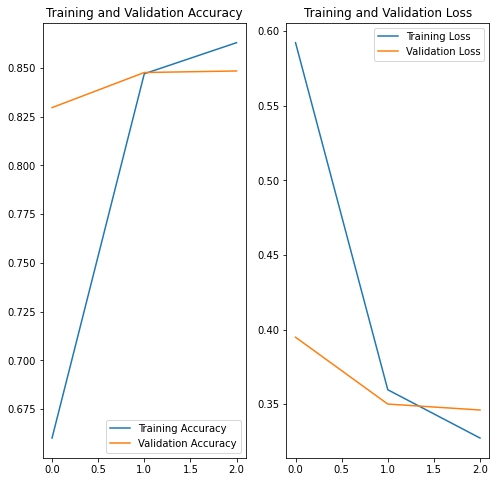

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_round)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predictions

In [ ]:
result_label = ["Bad", "Good"]

# sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
sample_text = ('The movie was good, I love the graphics.')

predictions = model.predict(np.array([sample_text]))

maxIndex = np.argmax(predictions)

print(result_label[maxIndex])
print(predictions)